In [3]:
!pip install yfinance pandas numpy matplotlib scikit-learn tensorflow


In [27]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM


In [33]:
# Download data for a stock (e.g., Apple)
ticker = 'AAPL'
df = yf.download(ticker, start='2015-01-01', end='2024-12-31')

# Use only 'Close' price for prediction
data = df[['Close']]
data.head()


C:\Users\zoneg\AppData\Local\Temp\ipykernel_10620\3199107487.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start='2015-01-01', end='2024-12-31')
[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,AAPL
Date,
2015-01-02,24.288582
2015-01-05,23.604338
2015-01-06,23.606556
2015-01-07,23.937574
2015-01-08,24.857298


In [35]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)


In [37]:
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - 60:]  # include lookback window

# Create sequences
def create_sequences(dataset, seq_length):
    x = []
    y = []
    for i in range(seq_length, len(dataset)):
        x.append(dataset[i-seq_length:i, 0])
        y.append(dataset[i, 0])
    return np.array(x), np.array(y)

seq_length = 60
x_train, y_train = create_sequences(train_data, seq_length)
x_test, y_test = create_sequences(test_data, seq_length)

# Reshape for LSTM input [samples, time steps, features]
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))


In [39]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


C:\Users\zoneg\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
model.fit(x_train, y_train, epochs=10, batch_size=32)


Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0276
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 3.4670e-04
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 3.0917e-04
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.6390e-04
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 2.8615e-04
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 2.7230e-04
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 2.9482e-04
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 2.2134e-04
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 2.2315e-04
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.0633e-04


In [42]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
actual = scaler.inverse_transform(y_test.reshape(-1, 1))


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


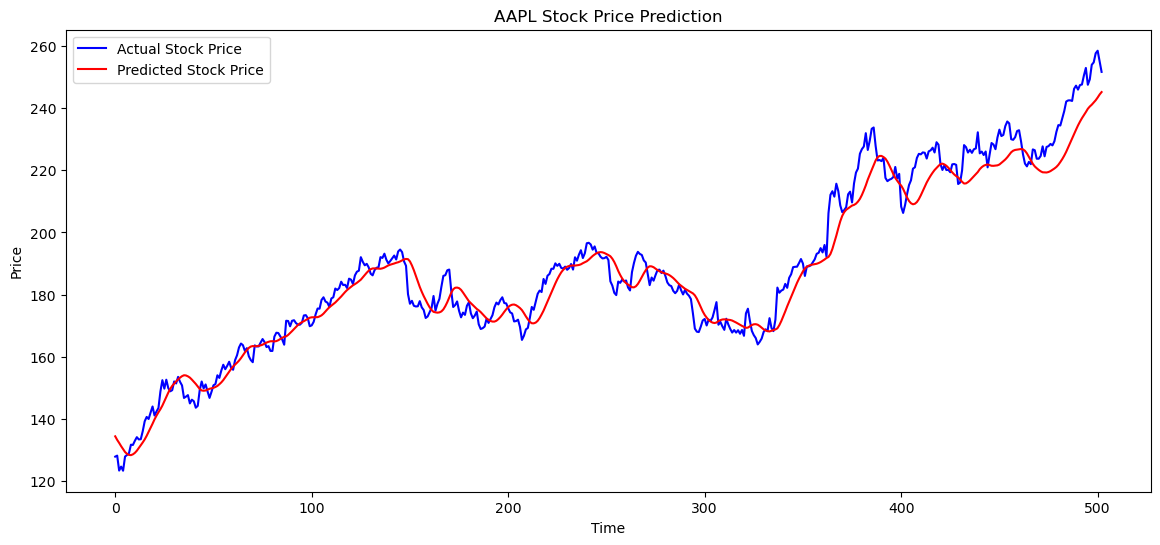

In [43]:
plt.figure(figsize=(14,6))
plt.plot(actual, color='blue', label='Actual Stock Price')
plt.plot(predictions, color='red', label='Predicted Stock Price')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [44]:
rmse = np.sqrt(mean_squared_error(actual, predictions))
print("RMSE:", rmse)


RMSE: 6.180450061554154
